In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score,
                             precision_recall_curve)
import plotly.express as px
!pip install pywaffle
from pywaffle import Waffle

In [17]:
df = pd.read_csv('/content/diabetes.csv')

df.replace('?', np.nan, inplace=True)
df['age'] = df['age'].str.replace('[^0-9]+', '', regex=True).astype(float)
df['weight'] = df['weight'].str.extract('(\d+)').astype(float)

<ipython-input-18-6c4026194675>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




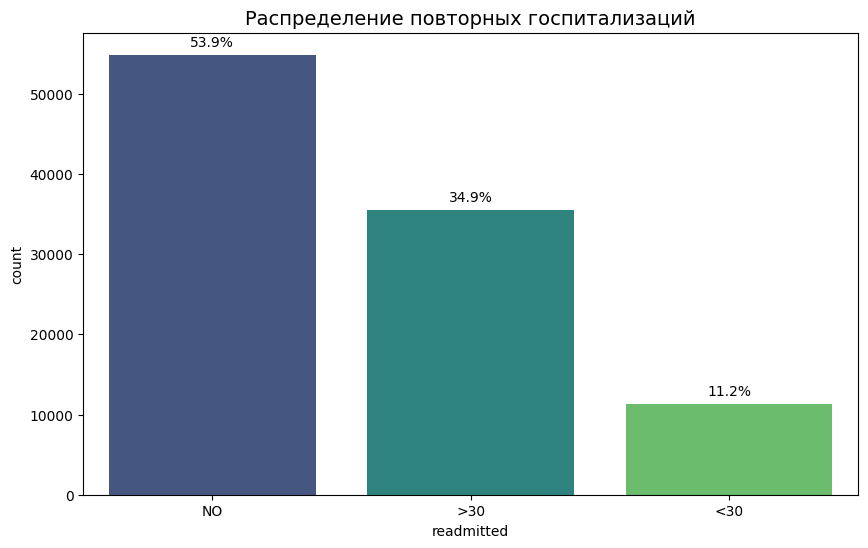

In [18]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='readmitted', data=df, palette='viridis')
plt.title('Распределение повторных госпитализаций', fontsize=14)
for p in ax.patches:
    ax.annotate(f'{p.get_height()/len(df)*100:.1f}%',
                (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0,9),
                textcoords='offset points')
plt.show()

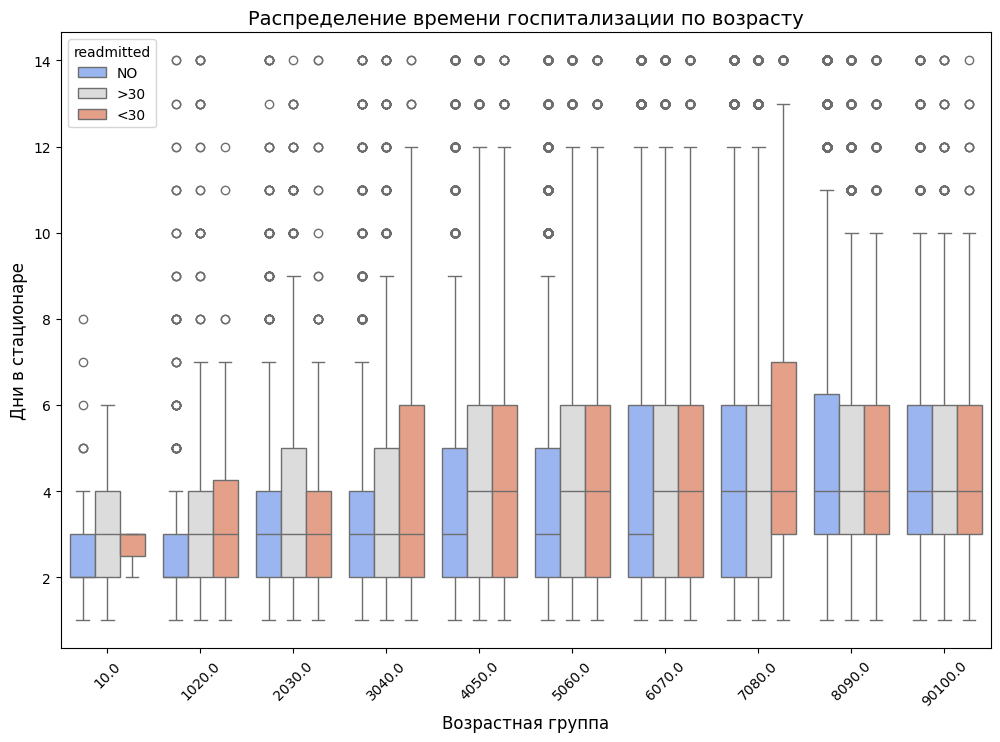

In [19]:
plt.figure(figsize=(12,8))
sns.boxplot(x='age', y='time_in_hospital',
            hue='readmitted', data=df,
            palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Распределение времени госпитализации по возрасту', fontsize=14)
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Дни в стационаре', fontsize=12)
plt.show()

In [22]:
diag_cols = ['diag_1', 'diag_2', 'diag_3']
diag_df = pd.melt(df[diag_cols]).dropna()

fig = px.sunburst(diag_df, path=['variable', 'value'],
                  color_discrete_sequence=px.colors.qualitative.Pastel,
                  title='Распределение диагностических кодов')
fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

In [23]:
gender_count = df['gender'].value_counts()
gender_count

,count
gender,
Female,54708
Male,47055
Unknown/Invalid,3


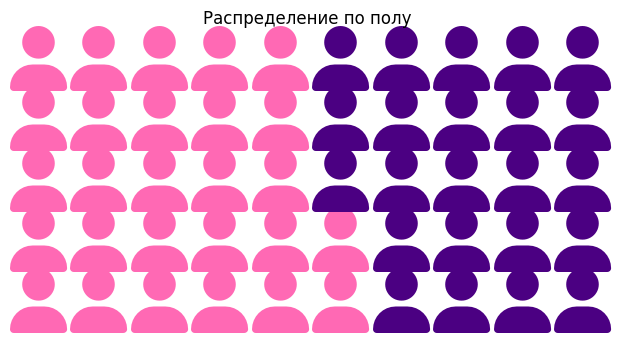

In [10]:
plt.figure(FigureClass=Waffle,
           rows=5,
           columns=10,
           values=gender_count,
           colors=['#FF69B4', '#4B0082', '#AA23DD'],
           legend={'loc': 'upper left'},
           title={'label': 'Распределение по полу', 'loc': 'center'},
           icons='user')
plt.show()

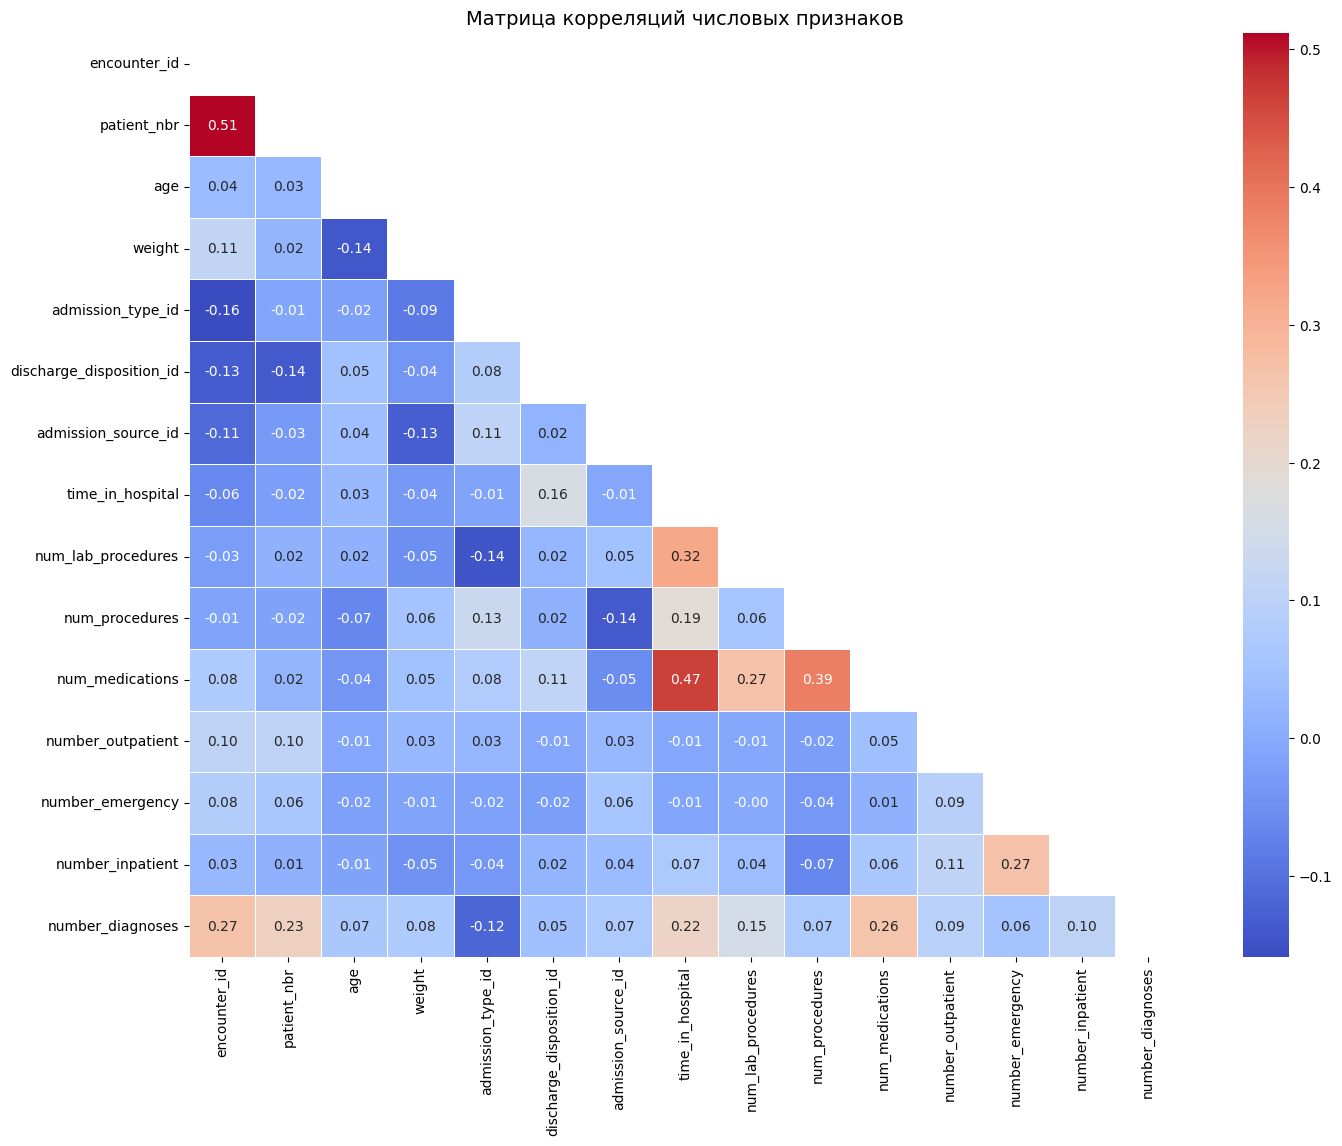

In [11]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, mask=mask,
            annot=True, fmt=".2f",
            cmap='coolwarm',
            linewidths=0.5)
plt.title('Матрица корреляций числовых признаков', fontsize=14)
plt.show()

<ipython-input-12-757372998bb2>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




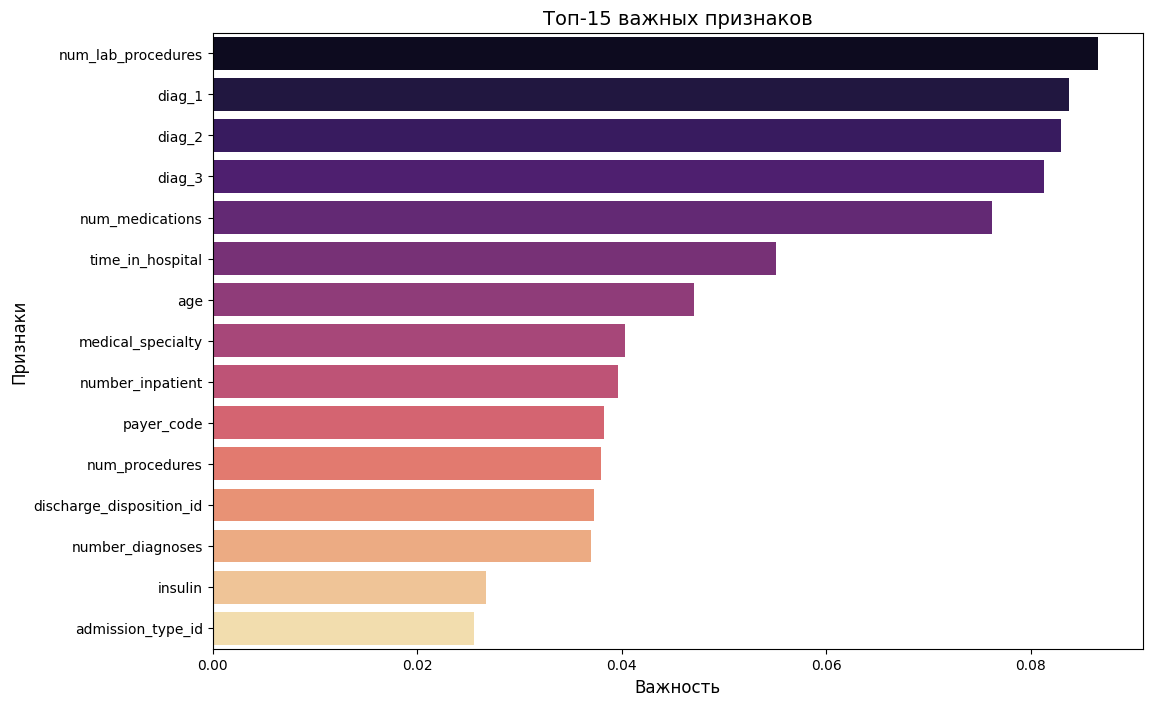

In [12]:
le = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop(['readmitted', 'encounter_id', 'patient_nbr'], axis=1)
y = df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=200,
                               class_weight='balanced',
                               random_state=42)
model.fit(X_train, y_train)

feature_imp = pd.Series(model.feature_importances_,
                        index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=feature_imp[:15], y=feature_imp.index[:15], palette='magma')
plt.title('Топ-15 важных признаков', fontsize=14)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.show()

Для своей модели я попытался взять как хорошие, важные признаки, так и не очень, чтобы посмотреть, как модель поведет себя

С одной стороны, модель сработала не лучшим образом, показав на пике 67% accuracy, а в среднем выдавая по батчу около 57-60%. В то же вермя, стоит учитывать не самую простую структуру датасета, а также необходимость сократить количетсво признаков. Графики выше наглядно демонстрируют, что в данных нет какого-то определяющего признака, основываясь на котором можно было бы решить задачу, а сокращение размерности приводит к огромным потерям важной информации